In [1]:
import numpy as np
import GPy
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

Problem?\
1-task ICM does not perform as well as SOGP in BOSS MT\
Solution?\
Fix hyperparameters so that $\bf{B} = [var]$

# Covariance functions

## RBF

$k_{RBF}(x,x') = \sigma^2e^{-(x-x')^2/2L^2}$

where\
$\sigma^2 = $ variance, scaling factor\
$L = $ lenghtscale, 'smoothness': large $L$ = smooth curve

## STDP

$k_{STDP}(x,x') = \sigma^2e^{-2\text{sin}^2(\pi|x-x'|)/pL^2}$

where\
$p = $ period

covariance functions may also be more complex, or they can be added or multiplied together for example to add support for multiple dimensions.


# SOGP kernel

$\bf{K} = \begin{pmatrix}
    k(\textbf{x}_1,\textbf{x}_1) & \dots & k(\textbf{x}_1,\textbf{x}_N) \\
    \vdots & \ddots & \vdots \\
    k(\textbf{x}_N,\textbf{x}_1) & \dots & k(\textbf{x}_N,\textbf{x}_N) \\
    \end{pmatrix}$,

where $N = $ number of inputs and
$k(\bf{x},\bf{x}') = $ valid covariance function for vector input $\bf{x} \in \mathbf{R}^d$

# Coregionalization kernels

Kernel and coregionalization matrix produce MT kernel.\
Now coregionalization matrix consumes the variance $\sigma^2$, so it is fixed to one in the covariance functions.

## LCM kernel

$\bf{K}_{LMC} = \sum_{q=1}^{Q}\bf{B}_q\otimes\bf{K}_q$ (see Kronecker product below)

## ICM kernel (Q = 1)

$\bf{K}_{IMC} = \bf{B}_1\otimes\bf{K}_1$

### Coregionalization matrix $\bf{B}_q$:
$\bf{B}_q = \bf{W}_q\bf{W}_q^\top$\
or (how it is in GPy, I have not yet found original source to this, althought it makes sense)\
$\bf{B}_q = \bf{W}_q\bf{W}_q^\top + diag(\bf{\kappa})$

where:\
$\bf{W}_q \in \mathbf{R}^{num\_tasks\times num_tasks}$ encodes correlation between tasks and has rank r, (autocorrelation, correlation, correlation, autocorrelation)\
$\bf{\kappa} \in \mathbf{R}^{num\_tasks}$ allows independence (or variance) of tasks, and\
$r \in \{1,...,num\_tasks\}$ is a grouping/complexity factor that may be used to group tasks that share covariance functions

### Kronecker product $\otimes$

$\begin{pmatrix} a & b \\ c & d\end{pmatrix} \otimes \begin{pmatrix} 1 & 2 \\ 3 & 4 \end{pmatrix} = \begin{pmatrix}  a1 & a2 & b1 & b2 \\ a3 & a4 & b3 & b4 \\ c1 & c2 & d1 & d2 \\ c3 & c4 & d3 & d4 \end{pmatrix}$

%\cite{harville1997matrix}
(harville1997matrix pp 333-

# GPr

Prior predictive for new observations:

\begin{equation}p(y_*,\textbf{y}|\textbf{x}_*,\textbf{X})
    \sim
    N\begin{pmatrix}
    \begin{matrix}
    m(\textbf{x}_1) \\ \vdots \\ m(\textbf{x}_j) \\ m(\textbf{x}_*)
    \end{matrix}
    ,
    \begin{matrix}
        \begin{pmatrix}
        k(\textbf{x}_1,\textbf{x}_1) & \dots & k(\textbf{x}_1,\textbf{x}_j) \\
        \vdots & \ddots & \vdots \\
        k(\textbf{x}_j,\textbf{x}_1) & \dots & k(\textbf{x}_j,\textbf{x}_j) \\
        \end{pmatrix}
        \begin{pmatrix}
        k(\textbf{x}_1,\textbf{x}_*) \\ \vdots \\ k(\textbf{x}_j,\textbf{x}_*)
        \end{pmatrix}
        \\
        \begin{pmatrix}
        k(\textbf{x}_*,\textbf{x}_1) & \dots & k(\textbf{x}_*,\textbf{x}_j) \\
        \end{pmatrix}
        \begin{pmatrix}
        k(\textbf{x}_*,\textbf{x}_*)
        \end{pmatrix}
    \end{matrix}
    \end{pmatrix}
    =
    N\begin{pmatrix}
    \begin{vmatrix}
    \bf{\mu} \\ \mu_*
    \end{vmatrix}
    ,
    \begin{vmatrix}
        \mathbf{K}
        & 
        \mathbf{K_*^\top}
        \\
        \mathbf{K_*}
        &
        \mathbf{K_{**}}
    \end{vmatrix}
    \end{pmatrix}
    .
\end{equation}

Posterior predictive:\
\begin{equation}
     p(y_*|\textbf{x}_*,\textbf{X},\textbf{y}) \sim N(\hat\mu,\hat\nu).
\end{equation}

The distribution parameters can be solved from:

\begin{equation}
\label{muhatsolution}
    \hat\mu = \mathbf{K}_*^\top\mathbf{K}^{-1}(\textbf{y}-\bf{\mu})+\mu_*
\end{equation}
and
\begin{equation}
\label{nuhatsolution}
    \hat\nu = \mathbf{K}_*^\top\mathbf{K}^{-1}\mathbf{K}_* + \mathbf{K}_{**}.
\end{equation}

## Coregionalization matrix with different setups

In [2]:
def coreg_B(W, kappa):
    print("W = \n", W)
    print("kappa = ", kappa)
    print("WW^T = \n", W.dot(W.T))
    print("diag(kappa) = \n", np.diag(kappa))
    print("B = WW^T + diag(kappa) = \n", W.dot(W.transpose())+np.diag(kappa))
    return W.dot(W.transpose())+np.diag(kappa)

### 1 task, Q = 1, r = 1


$\mathbf{W} = [w]$\
$\vec{\kappa} = [\kappa]$\
$\mathbf{B} = [b_{1,1}] = [w^2+\kappa]$\
$\mathbf{K}_\text{ICM} = b_{1,1}\mathbf{K}$

if $w1 = 0$, then\
$\mathbf{K}_\text{ICM} = \kappa\mathbf{K}$\
and thus $\kappa$ takes the role of variance $\sigma^2$ that was fixed to one.

In [3]:
W = np.array([1])
kappa = np.array([0.5])
B = coreg_B(W, kappa)

W = 
 [1]
kappa =  [0.5]
WW^T = 
 1
diag(kappa) = 
 [[0.5]]
B = WW^T + diag(kappa) = 
 [[1.5]]


### 2 tasks, Q = 1, r = 1

$\mathbf{W} = \begin{pmatrix} w_1 & w_2 \\ c*w_1 & c*w_2 \end{pmatrix}, c \in \bf{R}$

$\mathbf{W}\mathbf{W}^\top = \begin{pmatrix} w_1^2+w_2^2 & c*(w_1^2+w_2^2) \\ c*(w_1^2+w_2^2) & c^2(w_1^2+w_2^2) \end{pmatrix}$

$\vec{\kappa} = [\kappa_1\ \kappa_2]$

$diag(\vec{\kappa}) = \begin{pmatrix} \kappa_1 & 0 \\ 0 & \kappa_2\end{pmatrix}$

$\mathbf{B} = \begin{pmatrix} b_{1,1} & b_{1,2}\\
b_{2,1} & b_{2,2}\end{pmatrix} = \begin{pmatrix}w_1^2 + w_2^2 + \kappa_1 & w_1^2 + w_2^2 \\
w_1^2 + w_2^2 & w_1^2 + w_2^2 +\kappa_2 \end{pmatrix}$

$\mathbf{K}_\text{ICM} = \begin{pmatrix} b_{1,1}\mathbf{K} & b_{1,2}\mathbf{K}\\
b_{2,1}\mathbf{K} & b_{2,2}\mathbf{K}\end{pmatrix}$


In [4]:
W = np.array([[0.5,0.7],[0.5,0.7]])
kappa = np.array([0.1, 0.2])
B = coreg_B(W, kappa)

W = 
 [[0.5 0.7]
 [0.5 0.7]]
kappa =  [0.1 0.2]
WW^T = 
 [[0.74 0.74]
 [0.74 0.74]]
diag(kappa) = 
 [[0.1 0. ]
 [0.  0.2]]
B = WW^T + diag(kappa) = 
 [[0.84 0.74]
 [0.74 0.94]]


### 2 tasks, Q = 1, r = 2

$\mathbf{W} = \begin{pmatrix}w_{1,1} & w_{1,2} \\ w_{2,1} & w_{2,2}\end{pmatrix}$

$\mathbf{W}\mathbf{W}^\top = \begin{pmatrix}w_{1,1}^2 + w_{1,2}^2 & w_{1,1}w_{2,1} + w_{1,2}w_{2,2}\\ w_{1,1}w_{2,1} + w_{1,2}w_{2,2} & w_{2,1}^2 + w_{2,2}^2\end{pmatrix}$

Does rank >1 allow more independence already in the correlation part, without kappa?

$\vec{\kappa} = [\kappa_1\ \kappa_2]$

$diag(\vec{\kappa}) = \begin{pmatrix} \kappa_1 & 0 \\ 0 & \kappa_2\end{pmatrix}$

$\mathbf{B} = \begin{pmatrix} b_{1,1} & b_{1,2}\\
b_{2,1} & b_{2,2}\end{pmatrix} = \begin{pmatrix}w_{1,1}^2 + w_{1,2}^2 + \kappa_1 & w_{1,1}w_{2,1} + w_{1,2}w_{2,2}\\ w_{1,1}w_{2,1} + w_{1,2}w_{2,2} & w_{2,1}^2 + w_{2,2}^2 + \kappa_2 \end{pmatrix}$

$\mathbf{K}_\text{ICM} = \begin{pmatrix} b_{1,1}\mathbf{K} & b_{1,2}\mathbf{K}\\
b_{2,1}\mathbf{K} & b_{2,2}\mathbf{K}\end{pmatrix}$



In [5]:
# len(kappa) = 2
W = np.array([[0.5,0],[0.5,0]])
kappa = np.array([0.1, 0.2])
B = coreg_B(W, kappa)

W = 
 [[0.5 0. ]
 [0.5 0. ]]
kappa =  [0.1 0.2]
WW^T = 
 [[0.25 0.25]
 [0.25 0.25]]
diag(kappa) = 
 [[0.1 0. ]
 [0.  0.2]]
B = WW^T + diag(kappa) = 
 [[0.35 0.25]
 [0.25 0.45]]


### 1 task, Q = 2, r = 1 (LMC) ! definitely overfitting, but just to show how it works

$\mathbf{W}^{q_1} = [w^{q_1}]$

$\mathbf{W}^{q_2} = [w^{q_2}]$

$\vec{\kappa}^{q_1} = [\kappa^{q_1}]$

$\vec{\kappa}^{q_2} = [\kappa^{q_2}]$

$\mathbf{B}^{q_1} = [b^{q_1}_{1,1}] = [{w^{q_1}}^2+\kappa^{q_1}]$

$\mathbf{B}^{q_2} = [b^{q_2}_{1,1}] = [{w^{q_2}}^2+\kappa^{q_2}]$

$\mathbf{K}_\text{LCM} = \sum_{q=1}^2{b^q\otimes\bf{K}} = b^{q_1}_{1,1}\mathbf{K} + b^{q_2}_{1,1}\mathbf{K} = (b^{q_1}_{1,1}+b^{q_2}_{1,1})\mathbf{K}$


### 2 tasks, Q = 2, r = 1 (LMC)

$\mathbf{W}^q = \begin{pmatrix} w^q_1 & w^q_2 \\ w^q_1 & w^q_2 \end{pmatrix}$

$\mathbf{W}^q{\mathbf{W}^q}^\top = \begin{pmatrix} {w^q_1}^2+{w^q_2}^2 & {w^q_1}^2+{w^q_2}^2 \\ {w^q_1}^2+{w^q_2}^2 & {w^q_1}^2+{w^q_2}^2\end{pmatrix}$

$\vec{\kappa}^q = [\kappa^q_1\ \kappa^q_2]$

$diag(\vec{\kappa}^q) = \begin{pmatrix} \kappa^q_1 & 0 \\ 0 & \kappa^q_2\end{pmatrix}$

$\mathbf{B}^q = \begin{pmatrix} b^q_{1,1} & b^q_{1,2}\\
b^q_{2,1} & b^q_{2,2}\end{pmatrix} = \begin{pmatrix} {w^q_1}^2+{w^q_2}^2+\kappa^q_1 & {w^q_1}^2+{w^q_2}^2 \\ {w^q_1}^2+{w^q_2}^2 & {w^q_1}^2+{w^q_2}^2+\kappa^q_2 \end{pmatrix}$

$\mathbf{K}_\text{LCM} = \sum_{q=1}^2{\bf{B}^q\otimes\bf{K}^{q}} = (\bf{B}^{q_1}+\bf{B}^{q_2})\otimes(\bf{K}^{q_1} + \bf{K}^{q_2}) = \begin{pmatrix} b^{q_1}_{1,1}\mathbf{K}^{q_1}& b^{q_1}_{1,2}\mathbf{K}^{q_1}\\
b^{q_1}_{2,1}\mathbf{K}^{q_1} & b^{q_1}_{2,2}\mathbf{K}^{q_2}\end{pmatrix}+\begin{pmatrix} b^{q_2}_{1,1}\mathbf{K}^{q_2}& b^{q_2}_{1,2}\mathbf{K}^{q_2}\\
b^{q_2}_{2,1}\mathbf{K}^{q_2} & b^{q_2}_{2,2}\mathbf{K}^{q_2}\end{pmatrix} $

So, with Q >1 you basically need to have different basic kernels that you wish to combine!


# Experimenting with kernels

## Kappa and W

## Load data

In [45]:
# load data
def load_data(filepath):
    exp = {}
    with open(filepath,'r') as f:
        data = json.load(f)
        xy = np.array(data['xy'])
        x1 = xy[:,:-1]
        x1 = np.hstack((x1, np.zeros((len(x1),1))))
        y1 = xy[:,-1]
        y1 = y1.reshape(len(y1),1)
        gmp = np.array(data['gmp'])
        gmp = gmp.reshape(len(gmp),-1)
        exp['gmp'] = gmp
        exp['x'] = x1
        exp['y'] = y1
        exp['initpts'] = data['initpts']
        exp['gp_hyperparam'] = np.array(data['GP_hyperparam'])
        data = None
    return exp

In [7]:
x1 = x2 = None
y1 = y2 = None

In [8]:
exp = load_data('../processed_data/a1a1/exp_1.json')
x1 = exp['x']
y1 = exp['y']

In [9]:
exp = load_data('../processed_data/a1b1/exp_1.json')
x2 = exp['x']
y2 = exp['y']

In [10]:
#y1

### Basic kernel

In [11]:
#def __init__(self, input_dim, variance=1., period=None, lengthscale=None, ARD1=False, ARD2=False, active_dims=None, name='std_periodic',useGPU=False):
#        super(StdPeriodic, self).__init__(input_dim, active_dims, name, useGPU=useGPU
input_dim = 2
variance = 1
basic_kernel = GPy.kern.src.standard_periodic.StdPeriodic(input_dim, period = 360)

In [12]:
print(basic_kernel)

  std_periodic.  |  value  |  constraints  |  priors
  variance       |    1.0  |      +ve      |        
  period         |  360.0  |      +ve      |        
  lengthscale    |    1.0  |      +ve      |        


### ICM kernel

In [13]:
ICM1 = GPy.util.multioutput.ICM(input_dim=2,num_outputs=1,kernel=basic_kernel.copy())
print(ICM1)

  ICM.                      |         value  |  constraints  |  priors
  std_periodic.variance     |           1.0  |      +ve      |        
  std_periodic.period       |         360.0  |      +ve      |        
  std_periodic.lengthscale  |           1.0  |      +ve      |        
  B.W                       |  [1.16520473]  |               |        
  B.kappa                   |           0.5  |      +ve      |        


### Baseline

In [14]:
b1 = GPy.core.gp.GP(
            X = x1[:,:2].copy(),
            Y = y1.copy(),
            kernel = basic_kernel.copy(),
            likelihood = GPy.likelihoods.gaussian.Gaussian(),
            inference_method = GPy.inference.latent_function_inference.ExactGaussianInference(),
        name = "baseline_1task")
b1['.*variance'][0] = np.max(y1) - np.min(y1)
noise = 1e-12
b1.likelihood.fix(noise)
b1.optimize()
print(b1)


Name : baseline_1task
Objective : 164.39710062346737
Number of Parameters : 4
Number of Optimization Parameters : 3
Updates : True
Parameters:
  baseline_1task.           |               value  |  constraints  |  priors
  std_periodic.variance     |  159.24791746416997  |      +ve      |        
  std_periodic.period       |   359.4754153694438  |      +ve      |        
  std_periodic.lengthscale  |  0.5272194315748759  |      +ve      |        
  Gaussian_noise.variance   |               1e-12  |   +ve fixed   |        


In [15]:
87.10040125239115-87.10022559929514

0.00017565309600797718

In [16]:
88.3480006-88.34799559

5.010000009519899e-06

### 1 task, as in MT now, W not fixed to 0 but kappa initialized to basic kernel variance

In [17]:
m1 = GPy.core.gp.GP(
            X = x1.copy(),
            Y = y1.copy(),
            kernel = ICM1.copy(),
            likelihood = GPy.likelihoods.gaussian.Gaussian(),
            inference_method = GPy.inference.latent_function_inference.ExactGaussianInference(),
        name = "ICM_1task")
m1['.*variance'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m1['.*kappa'][0] = np.max(y1) - np.min(y1) # initialize kappa as variance
m1.likelihood.fix(noise)
m1.optimize()
print(m1)


Name : ICM_1task
Objective : 164.3971006235022
Number of Parameters : 6
Number of Optimization Parameters : 4
Updates : True
Parameters:
  ICM_1task.                    |               value  |  constraints  |  priors
  ICM.std_periodic.variance     |                 1.0  |   +ve fixed   |        
  ICM.std_periodic.period       |  359.47541361241724  |      +ve      |        
  ICM.std_periodic.lengthscale  |  0.5272194371584238  |      +ve      |        
  ICM.B.W                       |       [11.59366842]  |               |        
  ICM.B.kappa                   |  24.834693161843987  |      +ve      |        
  Gaussian_noise.variance       |               1e-12  |   +ve fixed   |        


In [18]:
print(m1.kern.B.B)

[[159.24784059]]


In [19]:
0.4360488260071347-0.4379830593931425

-0.0019342333860078442

### 1 task, Q =1, r = 1, W fixed to zero

In [20]:
m2 = GPy.core.gp.GP(
            X = x1.copy(),
            Y = y1.copy(),
            kernel = ICM1.copy(),
            likelihood = GPy.likelihoods.gaussian.Gaussian(),
            inference_method = GPy.inference.latent_function_inference.ExactGaussianInference(),
        name = "ICM_1task")
m2['.*variance'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m2['.*W'].constrain_fixed(0)
m2['.*kappa'][0] = np.max(y1) - np.min(y1) # initialize kappa as variance
m2.likelihood.fix(noise)
m2.optimize()
print(m2)


Name : ICM_1task
Objective : 164.3971006233386
Number of Parameters : 6
Number of Optimization Parameters : 3
Updates : True
Parameters:
  ICM_1task.                    |               value  |  constraints  |  priors
  ICM.std_periodic.variance     |                 1.0  |   +ve fixed   |        
  ICM.std_periodic.period       |   359.4754153694216  |      +ve      |        
  ICM.std_periodic.lengthscale  |  0.5272194315741711  |      +ve      |        
  ICM.B.W                       |                [0.]  |     fixed     |        
  ICM.B.kappa                   |  159.24791746197656  |      +ve      |        
  Gaussian_noise.variance       |               1e-12  |   +ve fixed   |        


In [21]:
m3 = GPy.core.gp.GP(
            X = x1.copy(),
            Y = y1.copy(),
            kernel = ICM1.copy(),
            likelihood = GPy.likelihoods.gaussian.Gaussian(),
            inference_method = GPy.inference.latent_function_inference.ExactGaussianInference(),
        name = "ICM_1task")
#m3['.*variance'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
#m3['.*kappa'][0] = np.max(y1) - np.min(y1) # initialize kappa as variance
noise = 0.001
m3.likelihood.fix(noise)
m3.optimize()
print(m3)


Name : ICM_1task
Objective : 164.43888081676158
Number of Parameters : 6
Number of Optimization Parameters : 5
Updates : True
Parameters:
  ICM_1task.                    |               value  |  constraints  |  priors
  ICM.std_periodic.variance     |   4.229474230893642  |      +ve      |        
  ICM.std_periodic.period       |  359.41420818897217  |      +ve      |        
  ICM.std_periodic.lengthscale  |  0.5347261381930946  |      +ve      |        
  ICM.B.W                       |        [6.17571263]  |               |        
  ICM.B.kappa                   |  0.6571572830814147  |      +ve      |        
  Gaussian_noise.variance       |               0.001  |   +ve fixed   |        


In [22]:
3.7694438556268395*(4.71127017**2+1.2418830856538645)

88.34803548660976

## B, covariance and correlation between tasks

In [23]:
# load data

In [24]:
LF2Ds = load_data('../processed_data/a1a1/exp_1.json')

In [25]:
HF2Ds = load_data('../processed_data/a1b1/exp_1.json')

In [26]:
#LF4Ds = load_data('../processed_data/sobol_queue/alanine4D_LF_sobol.json')

In [27]:
#HF4Ds = load_data('../processed_data/sobol_queue/alanine4D_HF_sobol.json')

In [28]:
#VHF4Ds = load_data('../processed_data/sobol_queue/alanine4D_VHF_sobol.json')

In [29]:
import cython

In [33]:
def B_cov_cor(task1, task2):
    # iterate observations
    # at each iteration, calculate covariance, pearsons correlation
    #  add observations to MOGP
    # save B
    t1 = task1.copy()
    t2 = task2.copy()
    t1['x'][:,-1] = 0
    t2['x'][:,-1] = 1
    X1 = X2 = Y1 = Y2 = None
    cov_iter = []
    pearsonr_iter = []
    B = []
    
    # create kernel
    input_dim = t1['x'].shape[1]-1
    kernel = GPy.kern.src.standard_periodic.StdPeriodic(input_dim, period = 360)
    for _ in range(input_dim-1):
        kernel = kernel.prod(kernel)
    icm = GPy.util.multioutput.ICM(input_dim=input_dim,
                                   num_outputs=2,
                                   kernel=kernel.copy(),
                                  W_rank = 1)



    for i in range(2,len(t1['x'])):
        X1 = t1['x'][:i+1]
        X2 = t2['x'][:i+1]
        Y1 = t1['y'][:i+1]
        Y1 = Y1-np.mean(Y1)
        Y2 = t2['y'][:i+1]
        Y2 = Y2-np.mean(Y2)
        # calculate covariance
        cov_iter.append(np.cov(Y1.T, Y2.T).flatten())
        # calculate pearsons correlation coefficient and P-values
        pearsonr_iter.append(pearsonr(Y1.flatten(), Y2.flatten()))
        # fit GP model with ICM and check B
        X = np.vstack((X1.copy(), X2.copy()))
        Y = np.hstack((Y1.copy(), Y2.copy()))
        Y = np.reshape(Y, (-1,1))
        m = GPy.core.gp.GP(
            X, Y,
            kernel = icm.copy(),
            likelihood = GPy.likelihoods.gaussian.Gaussian(),
            inference_method = GPy.inference.latent_function_inference.ExactGaussianInference()
        )
        m.Y_metadata = {'output_index':X[:,-1]}
        m['.*variance'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
        #m['.*W'][:,1].constrain_fixed(0.) # restrict number of par
        #m['.*W'].tie_to(m['.*W'])
        # parameter ties are not implemented
        # https://github.com/SheffieldML/GPy/issues/789
        # https://github.com/SheffieldML/GPy/issues/462
        m['.*kappa'][0] = np.max(y1) - np.min(y1) # initialize kappa as variance
        m.likelihood.fix(noise)
        m.optimize()
        print(m['.*W'])
        # save B
        B.append(m.kern.B.B.flatten())
        
    
    cov_iter = np.array(cov_iter)
    pearsonr_iter = np.array(pearsonr_iter)
    B = np.array(B)
    # return results
    return {'cov':cov_iter, 'cor':pearsonr_iter, 'B':B}


In [34]:
def plot_cov_B(covcorB):
    cov_iter = covcorB['cov']
    B = covcorB['B']
    
    fig, axs = plt.subplots(2,2,
                figsize = (10,10),
                sharex = 'all',
                sharey = 'all')

    # plot measured covariance
    axs[0,0].hlines(y = cov_iter[-1,0],
                    color = 'r', linestyle = 'dashed',
                    xmin = 0, xmax = 100,
                   label = 'autocovariance')
    axs[0,1].hlines(y = cov_iter[-1,1],
                    color = 'r', linestyle = 'dashed',
                    xmin = 0, xmax = 100,
                   label = 'cross covariance')
    axs[1,0].hlines(y = cov_iter[-1,2],
                    color = 'r', linestyle = 'dashed',
                    xmin = 0, xmax = 100,
                   label = 'cross covariance')
    axs[1,1].hlines(y = cov_iter[-1,3],
                    color = 'r', linestyle = 'dashed',
                    xmin = 0, xmax = 100,
                   label = 'autocovariance')
    # plot B

    axs[0,0].plot(B[:,0], color = 'blue',
                 label = 'b11')
    axs[0,1].plot(B[:,1], color = 'blue',
                 label = 'b12')
    axs[1,0].plot(B[:,2], color = 'blue',
                 label = 'b21')
    axs[1,1].plot(B[:,3], color = 'blue',
                 label = 'b22')

    for ax, enum in zip(axs.flatten(), ['a','b','c','d']):
        ax.legend()
        ax.set_title(f'{enum})', loc = 'left')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel("N")

In [35]:
covcorB2D = B_cov_cor(HF2Ds, LF2Ds)

  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.69960988  |               |        
  [1 0]  |  1.85273448  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.97267084  |               |        
  [1 0]  |   1.65935174  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.93508723  |               |        
  [1 0]  |   5.40883337  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -1.21670161  |               |        
  [1 0]  |  6.12649259  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.65499243  |               |        
  [1 0]  |   7.32280184  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  1.14460815  |               |        
  [1 0]  |  7.57923516  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  1.27756943  |               

  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.04118445  |               |        
  [1 0]  |  5.57346157  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.84899858  |               |        
  [1 0]  |  5.62869331  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.02100741  |               |        
  [1 0]  |  5.33420718  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.96125704  |               |        
  [1 0]  |   5.24707630  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.35114064  |               |        
  [1 0]  |   5.22940199  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.41873865  |               |        
  [1 0]  |   5.10762081  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.31499808  |              

  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  1.15980649  |               |        
  [1 0]  |  6.16044798  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  2.19175974  |               |        
  [1 0]  |  5.97752442  |               |        
  index  |  gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  0.67451873  |               |        
  [1 0]  |  6.13106808  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.29550074  |               |        
  [1 0]  |   6.18443888  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.40617629  |               |        
  [1 0]  |   6.23899255  |               |        
  index  |   gp.ICM.B.W  |  constraints  |  priors
  [0 0]  |  -0.52808411  |               |        
  [1 0]  |   6.21941230  |               |        


In [ ]:
# covariance matrix between HF2D and LF2D
covcorB2D['cov'][-1,:].reshape((2,2))

In [ ]:
# correlation between HD2D and LF2D
covcorB2D['cor'][-1,:]

In [ ]:
covcorB2D['B']

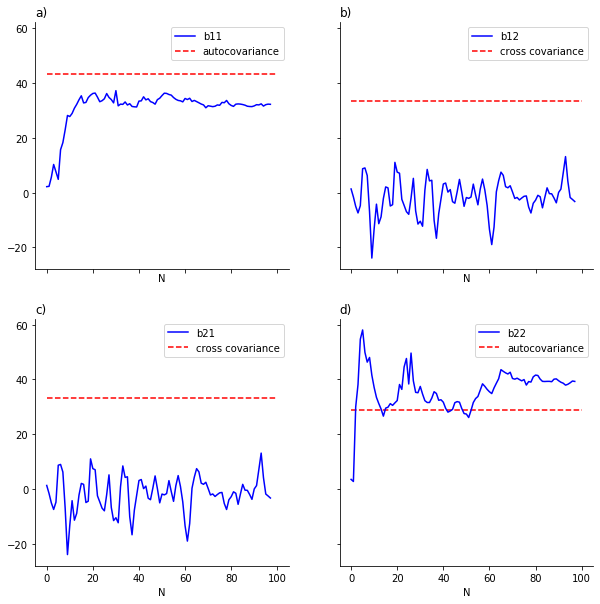

In [36]:
# using sobol points, there should be 
# cancellation of transfer of information (cross covariance = 0)
plot_cov_B(covcorB2D)

(array([ 1.,  2.,  2.,  6.,  9., 30., 24., 13.,  9.,  2.]),
 array([-23.91473894, -20.21313531, -16.51153168, -12.80992805,
         -9.10832442,  -5.40672079,  -1.70511716,   1.99648647,
          5.6980901 ,   9.39969372,  13.10129735]),
 <a list of 10 Patch objects>)

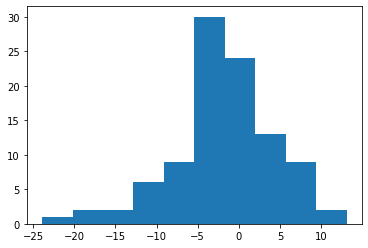

In [37]:
plt.hist(covcorB2D['B'][:,1])

In [83]:
hyperparams = []
for i in range(30):
    d = load_data(f'../processed_data/a1a2/exp_{i+1}.json')
    hyperparams.append(d['gp_hyperparam'].copy())
hyperparam_tensor = np.array(hyperparams_tensor).reshape((30,-1,3))
kstest(variance_last, 'gamma',
       args=(np.mean(variance_last), min(variance_last),
             1./7))

(array([2., 0., 5., 7., 5., 3., 3., 3., 1., 1.]),
 array([6.86750792, 6.89367906, 6.91985019, 6.94602133, 6.97219246,
        6.9983636 , 7.02453473, 7.05070587, 7.076877  , 7.10304814,
        7.12921927]),
 <a list of 10 Patch objects>)

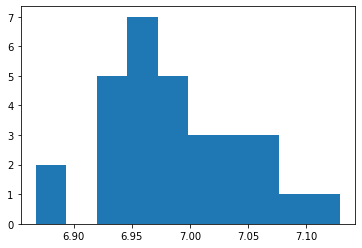

In [99]:
variance_last = hyperparams[:,-1,-1]
plt.hist(variance_last)
plt.plot()

### PSEUDOALGORITHM FOR PRIOR ESTIMATION

1. collect observations by experiment,iteration and hyperparameter
2. for each hyperparameter: for each iteration
3. calculate maximum likelihood for distribution parameters (gamma or gaussian)
4. calculate kolmorov-smirnov etc statistical test against true distribution
4. evaluate how parameters, test statistic and p-value evolve over time
5. use final approximations as priors for next experiments
6. repeat until the prior estimate does not change anymore

IndexError: too many indices for array

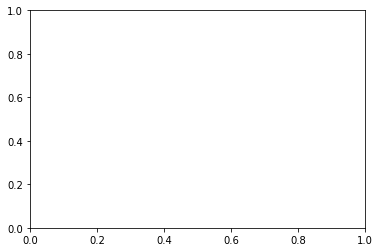

In [ ]:
# 4D
#np.cov(VHF4Ds['y'].T, LF4Ds['y'].T)

In [ ]:
#np.var(HF4Ds['y'].T)

In [ ]:
#np.cov(HF4Ds['y'].T, LF4Ds['y'].T)

In [ ]:
#pearsonr(VHF4Ds['y'].flatten(), HF4Ds['y'].flatten())

In [ ]:
#pearsonr(VHF4Ds['y'].flatten(), LF4Ds['y'].flatten())

## TL experiments and B

Do cross covariances approach measured cross-covariances?

In [ ]:
HF2Dtl = load_data('../processed_data/')

In [ ]:
def tl_B(exp):
    # calculate B by iteration for TL experiments
    initpts = sum(exp['initpts'])
    B_list = []
    for hyperparams in exp['gp_hyperparam']:
        # lengthscales W kappa
        W = hyperparams[-4:-2]
        kappa = hyperparams[-2:]
        B = W.dot(W.T) + np.diag(kappa)
        B = B.flatten()
        B = B/max(B[0], B[3])
        B_list.append(B)
    return np.array(B_list)

In [ ]:
Tsekkaa skaalat!

In [ ]:
#cv = np.atleast_2d(np.cov(VHF4Ds['y'].T, HF4Ds['y'].T).flatten())
#cv

In [ ]:
def loewner(A, B):
    # A>=B if 
    ret_list = []
    for b in B:
        D = (A-b).reshape((2,2))
        det = np.linalg.det(D)
        ret = 1
        if det < 0 or D[0,0] < 0:
            ret = 0
        ret_list.append(ret)
    return ret_list
        
        

In [ ]:
#np.mean(loewner(cv,tl_B(HF2Dtl)))

In [ ]:
#plot_cov_B({'cov':cv,
            'B':tl_B(HF2Dtl)})

## Comparing covariance matrices

using loewner order to determine how much secondary data is needed

Hypothesis:
Loewner order of estimated covariance and coregionalization matrix B can be used to estimate, whether there is enough secondary data to utilize transfer learning with confidence.

# Are BOSS experiments actually even reproducible?

In [ ]:
#with open('../processed_data/other/baseline.json','r') as f:
#    exp1 = json.load(f)

In [ ]:
#with open('../processed_data/other/baseline_reproduced.json','r') as f:
#    exp2 = json.load(f)

In [ ]:
#np.array(exp1['gmp'])[:,-1]-np.array(exp2['gmp'])[:,-1]

In [ ]:
#fig, axs = plt.subplots(1)
#axs.plot(np.array(exp1['gmp'])[:,-1])
#axs.plot(np.array(exp2['gmp'])[:,-1])

## BOSS
Covariance function:

Hyperparameter priors:
$d = y_{max}-y_{min}$\
$var = gammadist(2, 2/(d/2)^2)$\
$lengthscales = [gammadist(3.3678, 9.0204)_1, ..., gammadist(3.3678, 9.0204)_{dim}]$


In [ ]:
### STS thetainit
# default initial hyperparameters
        if self.thetainit is None:
            self.thetainit = [0.5 * (self.yrange[1] - self.yrange[0])] # sig
            for i in range(self.dim): # lengthscales
                if self.kerntype[i] == 'stdp': # pbc
                    self.thetainit.append(np.pi/10)
                else: # nonpbc
                    self.thetainit.append(self.periods[i]/20)


### kernelfactory
for i in range(STS.dim):
            if forced_hypers is None:
                if i == 0:
                    Ksi = STS.thetainit[0]
                else:
                    Ksi = 1.0
                Klsi = STS.thetainit[i + 1]
            else:
                Ksi = forced_hypers[0]
                Klsi = forced_hypers[1 + i]
            Kp = STS.periods[i]

            if STS.kerntype[i] == "stdp":
                kerns[i] = GPy.kern.StdPeriodic( ##########################
                    input_dim=1,
                    variance=Ksi,
                    period=Kp,
                    lengthscale=Klsi,
                    ARD1=True,
                    ARD2=True,
                    active_dims=[i],
                    name="kern",
                )
                
### GPy stdperiodic
def __init__(self, input_dim, variance=1., period=None, lengthscale=None, ARD1=False, ARD2=False, active_dims=None, name='std_periodic',useGPU=False):
        super(StdPeriodic, self).__init__(input_dim, active_dims, name, useGPU=useGPU)
        self.ARD1 = ARD1 # correspond to periods
        self.ARD2 = ARD2 # correspond to lengthscales

        self.name = name

        if self.ARD1 == False:
            if period is not None: #### shared
                period = np.asarray(period)
                assert period.size == 1, "Only one period needed for non-ARD kernel"
            else:
                period = np.ones(1)
        else:
            if period is not None:
                period = np.asarray(period)
                assert period.size == input_dim, "bad number of periods"
            else:
                period = np.ones(input_dim)

        if self.ARD2 == False: ##### shared
            if lengthscale is not None:
                lengthscale = np.asarray(lengthscale)
                assert lengthscale.size == 1, "Only one lengthscale needed for non-ARD kernel"
            else:
                lengthscale = np.ones(1)
        else:
            if lengthscale is not None:
                lengthscale = np.asarray(lengthscale)
                assert lengthscale.size == input_dim, "bad number of lengthscales"
            else:
                lengthscale = np.ones(input_dim)

        self.variance = Param('variance', variance, Logexp()) ############### variance
        assert self.variance.size==1, "Variance size must be one"
        self.period =  Param('period', period, Logexp())
        self.lengthscale =  Param('lengthscale', lengthscale, Logexp())

        self.link_parameters(self.variance,  self.period, self.lengthscale)


## BOSS-MT (currently)
GPy defaults




In [ ]:
#-- default hyperparameter priors
        if self.thetapriorpar is None and self.thetaprior is not None:
            if self.thetaprior == "gamma":
                self.thetapriorpar = [[1,1]] # not used, but must be passed to kernelfactory initialized
            else:
                raise TypeError("Unknown options set for thetaprior: '"
                                + self.thetaprior + "'.")

            for i in range(self.dim):
                if self.thetaprior == "gamma":
                    if self.kerntype[i] == 'stdp': # pbc
                        shape = 3.3678
                        rate = 9.0204
                    else: # nonpbc
                        shape, rate = Distributions.gammaparams(
                            self.periods[i]/20, self.periods[i]/2
                                                 )
                    self.thetapriorpar.append([shape, rate])
                else:
                    raise TypeError("Unknown options set for \
                                    K_priortype: '" + self.thetaprior + "'.")

# default initial hyperparameters
        if self.thetainit is None:
            self.thetainit = [1] # var fixed, change kernel constructer later so that it does not need
            for i in range(self.dim): # lengthscales
                if self.kerntype[i] == 'stdp': # pbc
                    self.thetainit.append(np.pi/10)
                else: # nonpbc
                    self.thetainit.append(self.periods[i]/20)


### BOSS MT
self.kernel = GPy.util.multioutput.LCM(dim, num_tasks, kernels_list, W_rank)
        # set kernel variance fixed to 1 (gpy sets the same variance for all kernels)
self.kernel.kern.variance.constrain_fixed(1)

### multioutput
def ICM(input_dim, num_outputs, kernel, W_rank=1,W=None,kappa=None,name='ICM'):
    """
    Builds a kernel for an Intrinsic Coregionalization Model

    :input_dim: Input dimensionality (does not include dimension of indices)
    :num_outputs: Number of outputs
    :param kernel: kernel that will be multiplied by the coregionalize kernel (matrix B).
    :type kernel: a GPy kernel
    :param W_rank: number tuples of the corregionalization parameters 'W'
    :type W_rank: integer
    """
    if kernel.input_dim != input_dim:
        kernel.input_dim = input_dim
        warnings.warn("kernel's input dimension overwritten to fit input_dim parameter.")

    K = kernel.prod(GPy.kern.Coregionalize(1, num_outputs, active_dims=[input_dim], rank=W_rank,W=W,kappa=kappa,name='B'),name=name)
    return K
def LCM(input_dim, num_outputs, kernels_list, W_rank=1,name='ICM'):
    """
    Builds a kernel for an Linear Coregionalization Model

    :input_dim: Input dimensionality (does not include dimension of indices)
    :num_outputs: Number of outputs
    :param kernel: kernel that will be multiplied by the coregionalize kernel (matrix B).
    :type kernel: a GPy kernel
    :param W_rank: number tuples of the corregionalization parameters 'W'
    :type W_rank: integer
    """
    Nk = len(kernels_list)
    K = ICM(input_dim,num_outputs,kernels_list[0],W_rank,name='%s%s' %(name,0))
    j = 1
    for kernel in kernels_list[1:]:
        K += ICM(input_dim,num_outputs,kernel,W_rank,name='%s%s' %(name,j))
        j += 1
    return K
### coregionalize

def __init__(self, input_dim, output_dim, rank=1, W=None, kappa=None, active_dims=None, name='coregion'):
        super(Coregionalize, self).__init__(input_dim, active_dims, name=name)
        self.output_dim = output_dim
        self.rank = rank
        if self.rank>output_dim:
            print("Warning: Unusual choice of rank, it should normally be less than the output_dim.")
        if W is None:
            W = 0.5*np.random.randn(self.output_dim, self.rank)/np.sqrt(self.rank)
        else:
            assert W.shape==(self.output_dim, self.rank)
        self.W = Param('W', W)
        if kappa is None:
            kappa = 0.5*np.ones(self.output_dim)
        else:
            assert kappa.shape==(self.output_dim, )
        self.kappa = Param('kappa', kappa, Logexp())
        self.link_parameters(self.W, self.kappa)

[docs]    def parameters_changed(self):
        self.B = np.dot(self.W, self.W.T) + np.diag(self.kappa)

## BOSS-MT (as should)